# 02_Getting started with neural networks

## Title

- 2.2 Layers: the building blocks of deep learning
- 2.3 Models: networks of layers
- 2.4 Loss functions and optimizers: keys to configuring the learning process
- 2.5 Vanishing/Exploding Gradients Problems
    - 2.5.1 Xavier and He Initialization
    - 2.5.2 Nonsaturating Activation Functions
- 2.6 MNIST Classifier with SELU
- 2.7 Batch Normalization
- 2.8 Classifying movie reviews: a binary classification example 
    - 2.8.1 The IMDB dataset
    - 2.8.2 Preparing the data
    - 2.8.3 Building your network
    - 2.8.4 Validating your approach
    - 2.8.5 Using a trained network to generate predictions on new data

## Setup

In [1]:
%run setup.py

<br>

## 2.1 Anatomy of a neural network

신경망 훈련에는 다음 요소들이 관련되어 있습니다.  
- 네트워크(모델)를 구성하는 층  
- 입력 데이터와 그에 상응하는 타깃  
- 학습에 사용할 피드백 신호를 정의하는 손실 함수  
- 학습 진행 방식을 결정하는 옵티마이저  

이들 간의 상호 작용은 아래 그림과 같습니다. 연속된 층으로 구성된 네트워크가 입력 데이터를 기준 예측으로 매핑합니다. 손실 함수는 예측과 타겟을 비교하여 네트워크의 예측이 기댓값에 얼마나 잘 맞는지를 측정하는 손실 값을 만듭니다. 옵티마이저는 손실값을 사용하여 네트워크 가중치를 업데이트합니다.

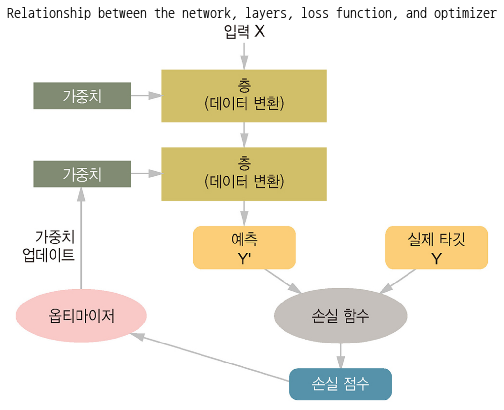

In [2]:
plt.figure(figsize=(12, 7))
plt.title("Relationship between the network, layers, loss function, and optimizer", fontsize=14)
plot_external2("./images/ch02/1.png")
plt.show()

<br>

## 2.2 Layers: the building blocks of deep learning

신경망의 핵심적인 데이터 구조는 층(layer)입니다. 층은 하나 이상의 텐서를 입력으로 받아 하나 이상의 텐서를 출력하는 데이터 처리 모듈입니다. 어떤 종류의 층은 상태가 없지만 대부분의 경우 가중치라는 층의 상태를 가집니다(Flatten, Pooling, Dropout층에는 학습되는 가중치가 없습니다). 가중치는 확률적 경사하강법에 의해 학습되는 하나 이상의 텐서이며 여기에 네트워크가 학습한 지식이 담겨 있습니다.  

층마다 적절한 텐서 포맷과 데이터 처리 방식이 다릅니다. 예를 들어 (samples, features)크기의 2D 텐서가 저장된 간단한 벡터 데이터는 완전 연결 층(fully connected layer)이나 밀집 층(dense layer)이라고도 불리는 밀집 연결층(densely connected layer)에 의해 처리되는 경우가 많습니다. (samples, timesteps, features) 크기의 3D 텐서로 저장된 시퀀스 데이터는 보통 LSTM같은 순환 층(recurrent layer)에 의해 처리됩니다. 4D 텐서로 저장되어 있는 이미지 데이터는 일반적으로 2D 합성곱 층(convolution layer)에 의해 처리됩니다(Conv2D 클래스).  

층을 딥러닝의 레고 블럭처럼 생각할 수 있습니다. 이런 비유는 케라스 같은 프레임워크 때문에 생겼습니다. 케라스에서는 호환 가능한 층들을 엮어 데이터 변환 파이프라인을 구성함으로써 딥러닝 모델을 만듭니다. 여기에서 층 호환성(layer compatibility)은 층이 특정 크기의 입력 텐서만 받고 특정 크기의 출력 텐서를 반환한다는 사실을 말합니다.

In [ ]:
clear_session()
from tensorflow.keras import layers
layer = layers.Dense(32, input_shape=(784, ))

첫 번째 차원이 784인 2D 텐서만 입력으로 받는 층을 만들었습니다(배치 차원인 0번째 축은 지정하지 않기 때문에 어떤 배치 크기도 입력으로 받을 수 있습니다). 이 층은 첫번째 차원 크기가 32로 변환된 텐서를 출력할 것입니다. 따라서 이 층에는 32차원의 벡터를 입력으로 받는 하위 층이 연결되어야 합니다 케라스에서는 모델에 추가된 층을 자동으로 상위 층의 크기에 맞추어 줍니다.

In [4]:
model = tf.keras.Sequential()
model.add(layers.Dense(32, input_shape=(784, )))
model.add(layers.Dense(10))

두번째 층에는 input_shape 매개변수를 지정하지 않았습니다. 그 대신 앞선 층의 출력 크기를 입력 크기로 자동으로 채택합니다.

<br>

## 2.3 Models: networks of layers

딥러닝 모델은 층으로 마든 비순환 유향 그래프(Directed Acyclic Graph, DAG: 한 노드에서 다시 자기자신으로 돌아올 경로가 없는 그래프)입니다. 가장 일반적인 예가 하나의 입력을 하나의 출력으로 매핑하는 층을 순서대로 쌓는 것입니다.  

네트워크 구조는 가설 공간(hypothesis space)을 정의합니다. 네트워크 구조를 선택함으로써 가능성 있는 공간(가설 공간)을 입력 데이터에서 출력 데이터로 매핑하는 일련의 특정 텐서 연산으로 제한하게 됩니다. 우리가 찾아야 할 것은 이런 텐서 연산에 포함된 가중치텐서의 좋은 값입니다.  

딱 맞는 네트워크 구조를 찾아내는 것은 예술에 가깝습니다.

<br>

# 2.4 Loss functions and optimizers: keys to configuring the learning process

네트워크 구조를 정의하고 나면 2가지를 더 선택해야 합니다.  
- 손실 함수(loss function)(목적함수 objective function): 훈련하는 동안 최소화될 값입니다. 주어진 문제에 대한 성공 지표가 됩니다.  
- 옵티마이저(optimizer): 손실 함수를 기반으로 네트워크가 어떻게 업데이트될지 결정합니다. 특정 종류의 확률적 경사하강법(SGD)을 구현합니다.  

여러 개의 출력을 내는 신경망은 여러 개의 손실 함수를 가질 수 있습니다(출력당 하나씩). 하지만 경사 하강법 과정은 하나의 스클라 손실 값을 기준으로 합니다. 따라서 손실이 여러 개인 네트워크에서는 모든 손실이 (평균을 내서) 하나의 스칼라 양으로 합쳐집니다.  

문제에 맞는 올바른 목적 함수를 선택하는 것은 아주 중요합니다. 네트워크가 손실을 최소화하기 위해 편법을 사용할 수 있기 때문입니다. 목적 함수가 주어진 문제의 성공과 전혀 관련이 없다면 원하지 않는 일을 수행하는 모델이 만들어질 것입니다.  

2개의 클래스가 있는 분류 문제에는 "binary crossentropy", 여러개의 클래스가 있는 분류문제에서는 "categorical crossentropy", 회귀 문제에는 "RMSE(Root Mean Square Error)", 시퀀스 학습 문제이는 CTC(Connection Temporal Classification)

<br>

## 2.5 The problem: Gradient explosion and vanishing

역전파 알고리즘은 출력 레이어에서 입력 레이어로 이동하여 오차 그래디언트를 전파합니다. 알고리즘이 네트워크의 각 매개 변수와 관련하여 비용 함수의 그래디언트를 계산하면 경사 하강법 단계에서 각 매개 변수를 Gradient Descent 단계로 업데이트합니다.  

불행하게도, 그레디언트는 알고리즘이 하위 레이어로 진행함에 따라 종종 작아지고 작아집니다. 결국 경사 하강법이 하위층의 연결 가중치를 실제 변경되지 않은 채로 둔다면 훈련이 좋은 솔루션으로 수렴되지 않습니다. 이 문제를 **그래디언트 소실**이라고 합니다. 경우에 따라 그 반대가 발생할 수 있습니다. 즉, 그래디언트가 커질 수 있기 때문에 많은 레이어가 엄청나게 큰 가중치 업데이트를 가져오고 알고리즘이 발산하게 됩니다. 이 문제를 **그래디언트 폭주**라고 하며 순환 신경망에서 주로 나타납니다. 일반적으로 심층 신경망은 불안정한 그래디언트에 영향을 많이 받습니다. 여러 층이 서로 다른 속도로 학습될 수 있기 때문입니다.  

초기에는 로지스틱 시그모이드 활성화 함수와 그 당시 가장 인기 있었던 가중치 초기화 방법의 조합이 있었습니다. 즉, 평균 0과 표준 편차 1의 정규 분포를 사용한 무작위 초기화입니다. 즉,이 활성화 함수와이 초기화 방식을 사용하면 각 레이어의 출력의 분산이 입력의 분산보다 훨씬 큽니다. 신경망의 위쪽으로 갈수록 층을 지날 때마다 분산이 계속 커져 가장 높은 층에서는 활성화 함수가 0이나 1로 수렴합니다.이는 로지스틱 함수의 평균이 0이 아닌 0.5이기 때문에 더 나빠집니다.(쌍곡선 탄젠트 함수는 평균이 0이고 깊은 신경망에서의 로지스틱 함수보다 약간 더 낫습니다).

In [35]:
def logit(z):
    return 1 / (1 + np.exp(-z))

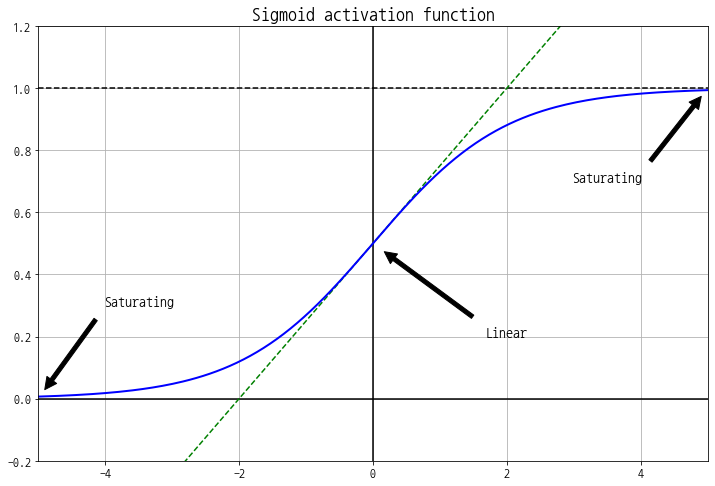

In [36]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(12, 8))
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=18)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

로지스틱 활성화 함수를 보면 입력 값이 커지면 (음수 또는 양수) 함수가 0 또는 1로 수렴하고 매우 미분이 0에 가까워짐을 알 수 있습니다. 따라서 역전파가 시작될 때, 신경망 통해 다시 전파되는 그라디언트가 거의 없으며 상위 전파층을 통해 전파 전파가 진행됨에 따라 희석되는 희박한 그래디언트가 있으므로 하위층에는 아무 것도 남지 않았습니다.

### 2.5.1 Xavier and He Initialization

글로럿과 벤지오는 그들의 논문에서 이 문제를 크게 완화시키는 방법을 제안합니다. 예측을 할 때는 정방향으로, 그래디언트를 역전파할 때는 역방향으로 양방향 신호가 적헐하게 흘러야 합니다. 신호가 죽거나 폭주 또는 소멸하지 않아야 합니다. 그들은 적절한 신호가 흐르기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다고 주장합니다. 그리고 역방향에서 층을 통과하기 전과 후의 그래디언트 분산이 동일해야 합니다. 사실 층의 입력과 출력 연결 갯수가 같지 않다면 이 2가지를 보장할 수 없습니다. 하지만 그들은 실전에서 매우 잘 작동한다고 입증된 대안을 제안하였습니다. 연결 가중치 다음 식으로 무작위로 초기화하는 것입니다.  

**세이비어 초기화(로지스틱 활성화 함수를 사용했을 때)**

$$
mean\; is \;0\; ,standard \;deviation\; \sigma=\sqrt{ \frac{2}{n_{inputs} + n_{outputs}} } \\
or\; r=\sqrt{ \frac{6}{n_{inputs} + n_{outputs}} }:\; uniform\; distribution\; -r\;and \,+r\
$$  
입력의 연결 갯수가 대략 출력의 연결갯수와 비슷하면 더 간단한 공식을 사용합니다.  
($\sigma=1\diagup\sqrt{n_{inputs}}$또는 $r=\sqrt{3}\diagup\sqrt{n_{inputs}}$)  
세이비어 초기화 전략을 사용하면 훈련 속도를 상당히 높일 수 있습니다. 이 것이 현재 딥러닝의 성공을 견인한 기술 중 하나입니다. ReLU 활성화 함수를 위한 초기화 전략을 He 초기화라고 부릅니다.

In [46]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [47]:
clear_session()

In [48]:
n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

In [49]:
model = tf.keras.Sequential()
model.add(layers.Dense(n_hidden1, activation="relu", 
                       kernel_initializer="glorot_uniform", bias_initializer="zeros", 
                       input_shape=(n_hidden1, )))

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               90300     
Total params: 90,300
Trainable params: 90,300
Non-trainable params: 0
_________________________________________________________________


### 2.5.2 Nonsaturating Activation Functions

글로럿과 벤지오의 2010년 논문에서 얻은 통찰 중 하나는 활성화 함수를 잘못 선택하면 자칫 그래디언트의 소실이나 폭주로 이어질 수 있다는 것입니다. 그 전에는 대부분의 사람이 생물학전 뉴런의 방식과 비슷한 시그모이드 활성화 함수가 최선의 선택일 것이라고 생각했습니다. 하지만 다른 활성화 함수가 심층 신경망에서 훨씬 더 잘 작동한다는 사실이 밝혀졌습니다. 특히 ReLU함수는 특정 양숫값에 수렴하지 않는다는 커다란 장점이 있습니다.  

그러나 ReLU 함수는 0에서 미분이 안된다는 치명적인 단점이 있습니다. 그로인해 **dying ReLU**로 알려진 문제가 있습니다. 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않는다는 의미로 죽었다고 말합니다. 어떤 경우에는, 특히 큰 학습률을 사용하면 신경망의 뉴런 절반이 죽어 있기도 합니다. 훈련 도중 뉴런의 가중치가 바뀌어 가중치 합이 음수가 되면 그 다음부터 0을 출력하기 시작할 것입니다. ReLU함수는 입력이 음수면 그래디언트가 0이 되기 때문에 이런 일이 생기면 뉴런이 다시 살아나기 어렵습니다.  

이 문제를 해결하기 위해 **LeakyReLU** 같은 ReLU 함수의 변형을 사용하게 됩니다. 이 함수는 다음 식으로 표현됩니다.  
$$
    LeakyReLU_{\alpha}(z)=max(\alpha z,\, z)
$$
하이퍼파라미터 $\alpha$가 이 함수의 ***leaky***정도를 결정합니다. leaky 정도란 $z<0$일 때 이 함수의 기울기이며, 일반적으로 **0.01**로 설정합니다. 이 작은 기울기가 LeakyReLU를 절대 죽지 않게 만들어줍니다. 뉴런이 혼수상태에 오래 있을 수는 있지만 다시 깨어날 가능성을 얻게 됩니다. 최근 한 논문에서 여러 ReLU 함수의 변형을 비교해 얻은 결론 하나는 LeakyReLU가 ReLU보다 항상 성능이 높다는 것입니다. 사실 $\alpha=0.2$(많이 통과)로 하는 것이 $\alpha=0.01$(조금 통과)보다 더 나은 성능을 내는 것으로 보입니다. 이 논문은 훈련하는 동안 주이진 범위에서 $\alpha$를 무작위로 선택하고 테스트시에는 평균을 사용하는 **RReLU(Randomized Leaky ReLU)**도 평가했습니다. 이 함수도 꽤 잘 작동했으며(훈련 세트의 과대 적합 위험을 줄이는)규제의 역할을 하는 것처럼 보였습니다. 마지막으로 $\alpha$가 훈련하는 동안 학습되는 **Parametric Leaky ReLU**도 비교했습니다.(즉, 하이퍼파라미터가 아니고 다른 모델 파라미터와 마찬가지로 역전파에 의해 변경됩니다.)이 함수는 대규모 이미지 데이터셋에서는 ReLU보다 성능이 크게 앞섰지만, 소규모 데이터셋에서는 훈련 세트에 과대적합될 위험이 있습니다.

In [54]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

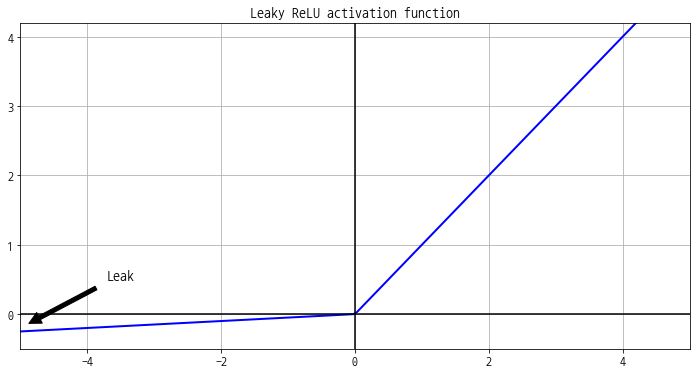

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

<br>

> ELU

또 하나의 중요한 함수는 2015년의 한 논문에서 제안한 **ELU(Exponential Linear Unit)**라는 새로운 **활성화 함수**입니다. 이 함수는 실험에서 다른 모든 ReLU 변종의 성능을 앞질렀습니다. 훈련 시간이 줄고 신경망의 테스트 세트 성능도 더 높았습니다. 이 함수는 다음과 같이 표현됩니다:  

$$
ELU_{\alpha}(z)=
\begin{cases}
\alpha(exp(z)-1) \qquad z<0\\
z \qquad \quad \quad \quad  \quad \; \,z \ge 0
\end{cases}
$$

In [56]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

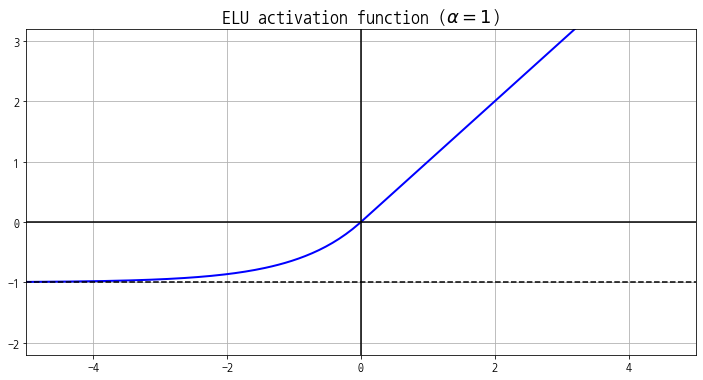

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=18)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

이 함수는 ReLU와 매우 비슷하지만 다음과 같은 차이점이 있습니다.  
- 1. $z < 0$일 때 음숫값이 들어오므로 활성화 함수의 평균 출력이 0에 더 가까워집니다. 이는 그래디언트 소실 문제를 완화해줍니다. 하이퍼파라미터 $\alpha$는 $z$가 큰 음숫값일 때 *ELU*가 수렴할 값을 정의합니다. 보통 1로 설정하지만 필요하면 다른 하이퍼파라미터처럼 원하는 값으로 변경할 수 있습니다.  

- 2. $z < 0$이어도 그래디언트가 0이 아니므로 죽은 뉴런을 만들지 않습니다.  

- 3. $\alpha=1$일 때 이 함수는 $z=0$에서 급격히 변동하지 않고 $z=0$을 포함해 모든 구간에서 매끄러워 경사하강법의 속도를 높여줍니다.  

ELU 활성화 함수의 주요 단점은 ReLU가 그 변종들보다(지수 함수를 사용하기 때문에) 계산이 느리다는 것입니다. 훈련하는 동안에는 수렴 속도가 빠르기 때문에 상쇄되지만 테스트 시에는 ELU신경망이 ReLU 신경망보다 느릴 것입니다.

심층 신경망의 은닉층에는 일반적으로 **ELU > LeakyReLU(etc...) > ReLU > tanh > Logistic** 순으로 사용하며 실행 속도가 중요하다면 LeakyReLU가 ELU보다 나을 수 있습니다. 하이퍼파라미터를 더 추가하고 싶지 않다면 앞서 추천한 기본 $\alpha$값을 사용합니다(LeakyReLU=0.01, ELU=1). 시간과 컴퓨팅 파워가 충분하다면 교차 검증을 사용해 여러 활성화 함수를 평가해볼 수 있습니다. 특히 신경망이 과대적합되었다면 RReLU, 훈련 세트가 아주 크다면 PReLU를 포함시키면 좋습니다.

<br>
<br>

>SELU

SELU 활성화 함수는 Günter Klambauer, Thomas Unterthiner, Andreas Mayr가 2017년에 쓴 논문에서 소개되었습니다. 훈련할 때 SELU 활성화 함수를 사용한 완전 연결 신경망은 스스로 정규화를 합니다. 각 층의 출력은 훈련하는 동안 같은 평균과 분산을 유지하려는 경향이 있어 그래디언트 소실과 폭주 문제를 해결합니다. 이 활성화 함수는 심층 신경망에서 다른 활성화 함수보다 뛰어난 성능을 내므로 꼭 이 함수를 시도해봐야 합니다. 식은 다음과 같습니다.  
$$SELU(x) = \lambda 
\begin{cases}
x \qquad \qquad \qquad if\; x>0 \\
\alpha(e^{x}-1) \qquad \quad \,if\; x \le 0
\end{cases}
$$

In [60]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [61]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

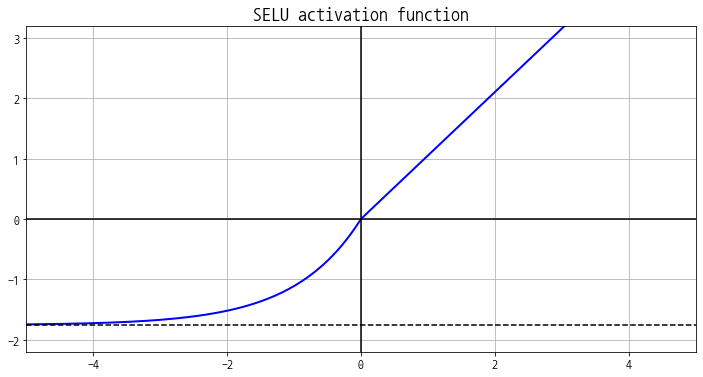

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=18)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [66]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) 
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {:3d}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer   0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


기본적으로 SELU 하이퍼파라미터(scale과 alpha)는 평균이 0, 표준 편차가 1에 가깝게 유지되도록 조정합니다(입력도 평균이 0, 표준 편차가 1로 표준화되었다고 가정합니다). 이 활성화 함수를 사용하면 100층으로 된 심층 신경망도 그래디언트 소실/폭주 문제없이 모든 층에서 대략 평균이 0이고 표준 편차가 1을 유지합니다:

## 2.6 MNIST Classifier with SELU

In [67]:
n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [71]:
# X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
# y = tf.placeholder(tf.int32, shape=(None), name="y")
from tensorflow.keras import layers, models

In [99]:
clear_session()
model = models.Sequential()

In [100]:
model.add(layers.Dense(n_hidden1, activation="selu", 
                       kernel_initializer="glorot_uniform", bias_initializer="zeros",
                       input_shape=(n_inputs, )))
model.add(layers.Dense(n_hidden2, activation="selu", 
                       kernel_initializer="glorot_uniform", bias_initializer="zeros"))
model.add(layers.Dense(n_outputs, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [101]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy

In [102]:
model.compile(optimizer=Adam(), 
              loss=sparse_categorical_crossentropy,
              metrics=[sparse_categorical_accuracy])

In [91]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [103]:
epochs = 40
class_mode = "sparse_categorical_accuracy"

In [104]:
%%time
history = model.fit(X_train, y_train, 
          epochs=epochs,
          batch_size=50,
          verbose=0,
          validation_data=(X_valid, y_valid),
          callbacks=[LossAndError(epochs=epochs, 
                                  class_mode=class_mode, 
                                  validation=True)])

epoch: 1, loss 0.28128, sparse_categorical_accuracy 0.91878       
history key: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']
Epoch 8/40 loss: 0.03582 sparse_categorical_accuracy: 0.98805 val_loss: 0.09192 val_sparse_categorical_accuracy: 0.97640
Epoch 16/40 loss: 0.01928 sparse_categorical_accuracy: 0.99376 val_loss: 0.11405 val_sparse_categorical_accuracy: 0.97940
Epoch 24/40 loss: 0.01280 sparse_categorical_accuracy: 0.99605 val_loss: 0.15400 val_sparse_categorical_accuracy: 0.97760
Epoch 32/40 loss: 0.01239 sparse_categorical_accuracy: 0.99678 val_loss: 0.16120 val_sparse_categorical_accuracy: 0.97880
Epoch 40/40 loss: 0.01193 sparse_categorical_accuracy: 0.99685 val_loss: 0.21457 val_sparse_categorical_accuracy: 0.97960
CPU times: user 15min 31s, sys: 6min 53s, total: 22min 24s
Wall time: 45min 7s


In [105]:
makedir("./models/ch02")
model.save("./models/ch02/mnist_with_selu_1.h5")

directory exist!!


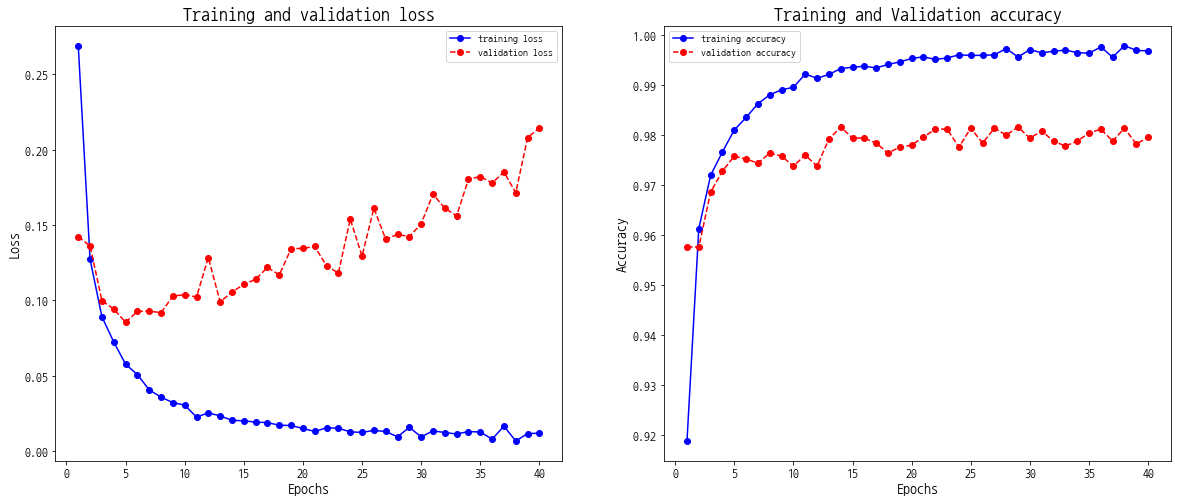

In [106]:
loss_and_acc_plot(history, class_mode="sparse_categorical_accuracy", validation=True)

## 2.7 Batch Normalization
각 은닉층의 활성화 함수 전에 배치 정규화를 추가하기 위해 ELU 활성화 함수를 배치 정규화 층 이후에 수동으로 적용합니다.

ELU(또는 다른 ReLU 변종)와 함께 He 초기화를 사용하면 훈련 초기 단계에서 그래디언트 소실이나 폭주 문제를 크게 감소시킬 수 있지만, 훈련하는 동안 다시 발생하지 않으리란 보장은 없습니다.  

2015년 한 논문에서 세르게이 아이오페와 크리스티안 세게디가 그래디언트 소실과 폭주 문제를 해결하기 위한 **Batch Normalization**기법을 제안했습니다. 더 일반적으로는 훈련하는 동안 이전 층의 파라미터가 변함에 따라 각 층에 들어오는 입력의 분포가 변화되는 문제입니다(**Internal Covariate Shift**문제)  

이 기법은 각 층에서 활성화 함수를 통과하기 전에 모델에 연산을 하나 추가합니다. 단순하게 입력 데이터의 평균을 0으로 만들고 정규화한 다음, 각 층에서 두 개의 새로운 파라미터로 결과값의 스케일을 조정하고 이동시킵니다(하나는 스케일 조정을 위해, 다른 하나는 이동을 위해 필요합니다). 다시 말해 이 연산으로 모델이 층마다 입력 데이터의 최적 스케일과 평균을 학습합니다.

입력 데이터의 평균을 0으로 만들고 정규화하려면 알고리즘은 평균과 표준편차를 추정해야 합니다. 이를 위해 현재 미니배치에서 입력의 평균과 표준편차를 평가합니다(그래서 이름이 **배치정규화**)  

**배치 정규화 알고리즘**   
$$\begin{split}
&1. \quad \mu_{B} = \frac{1}{m_{B}}\sum^{m_{B}}_{i=1}{(\mathbf{x})^{(i)}} \\
&2. \quad \sigma^{2}_{B} = \frac{1}{m_{B}}\sum^{m_{B}}_{i=1}{(\mathbf{x}^{(i)} - \mu_{B})}^{2}\\
&3. \quad \hat{ \mathbf{x} }^{(i)} = \frac{ \mathbf{x}^{(i)} - \mu_{B}}{ \sqrt{\sigma^{2}_{B} + \varepsilon} }\\
&4. \quad \mathbf{z}^{(i)} = \gamma\hat{ \mathbf{x} }^{(i)} + \beta
\end{split}
$$
- $\mu_{B}$는 미니배치 B에 대해 평가하여 관측한 평균  
- $\sigma_{B}$도 미니배치에 대해 평가하여 관측한 표준편차  
- $m_{B}$는 미니재치에 있는 샘플 수  
- $\hat{ \mathbf{x} }^{(i)}$은 평균이 0이고 정규화된 입력값  
- $\gamma$는 층의 스케일 파라미터  
- $\beta$는 층의 이동(편향)파라미터  
- $\varepsilon$은 분모가 0이 되는 것을 막기 위한 작은 숫자(전형적으로 $10^{-5}$)입니다. 이를 **smoothing term**(안전을 위한 항)  
- $\mathbf{z}^{(i)}$은 Batch Normal 연산의 출력. 즉 입력의 스케일을 조정하고 이동시킨 것

테스트할 때는 평균과 표준편차를 계산할 미니배치가 없으니 전체 훈련 세트의 평균과 표준편차를 대신 사용합니다. 이 값들은 훈련 과정에서 이동평균을 사용하여 효율적으로 계산되므로, 전체적으로 보면 배치 정규화된 층마다 $\gamma$(스케일), $\beta$(이동), $\mu$(평균), $\sigma$(표준편차) 네 개의 파라미터가 학습됩니다.  

이 기법으로 논문에서 실험했던 모든 심층 신경망의 성능이 크게 향상되었습니다. ***tanh***나 심지어 ***로지스틱 함수***같이 수렴되는 활성화 함수를 사용하더라도 그래디언트 소실 문제가 크게 감소되었습니다. 또한 네트워크가 가중치 초기화에 훨씬 덜 민감해집니다. 그리고 훨씬 큰 학습률을 사용할 수 있어 학습 속도를 크게 개선해줍니다. 특별히 이 논문에서 다음과 같이 언급되어 있습니다. ⌜가장 뛰어난 이미지 분류 모델에 적용하면 배치 정규화가 14배나 적은 훈련단계에서 같은 정확도를 달성하고 상당한 차이로 원래 모델을 앞지릅니다. 배치 정규화된 모델의 앙상블을 사용해 ImageNet 분류의 가장 뛰어난 수준에 도달했습니다.⌟마지막으로 배치 정규화는 규제와 같은 역할을 하여 드롭아웃 같은 규제 기법의 필요성을 줄여줍니다.  

그러나 (첫 번째 은닉층에 배치 정규화를 적용하면 입력 데이터를 정규화할 필요가 없어지지만) 배치 정규화는 모델의 복잡도를 키웁니다. 더군다나 실행 시간 면에서도 손해입니다. 층 마다 추가되는 계산이 신경망의 예측을 느려지게 합니다. 예측이 전광석화처럼 빨라야 한다면 배치 정규화를 사용하기 전에 ELU + He 초기화만으로 얼마나 잘 수행되는지 확인해보는 것이 좋습니다. 

*경사 하강법은 층마다 최적의 스케일과 이동을 위한 파라미터를 찾느라 훈련 초기에는 오히려 느려질 수 있습니다. 그러나 적절한 값을 찾고 나면 점점 빨라집니다.*

In [109]:
def mnist_load_data():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
    X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    X_valid, X_train = X_train[:5000], X_train[5000:]
    y_valid, y_train = y_train[:5000], y_train[5000:]
    
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = mnist_load_data()

Batch Normalization은 **exponential decay**를 사용해 이동평균을 계산합니다. 새로운 값 $v$가 주어지면 이동평균$\hat{v}$은 다음 식을 통해 갱신됩니다.  

$$\hat{v} \leftarrow \hat{v} \,\times\,momentum + v\,\times\,(1-momentum)$$  
적절한 모멘텀 값은 일반적으로 1에 가깝습니다. 데이터셋이 크고 미니배치가 작을 경우 1에 가깝게 합니다.

In [110]:
from tensorflow.keras import models, layers

In [ ]:
n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [116]:
clear_session()
model = models.Sequential()

In [117]:
model.add(layers.Dense(n_hidden1,                         
                       input_shape=(n_inputs, ),
                       kernel_initializer="he_normal"))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Activation("elu"))

model.add(layers.Dense(n_hidden2,                        
                       kernel_initializer="he_normal"))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Activation("elu"))


model.add(layers.Dense(n_outputs, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [119]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy

In [120]:
model.compile(optimizer = Adam(),
              loss      = sparse_categorical_crossentropy,
              metrics   = [sparse_top_k_categorical_accuracy])

In [121]:
epochs = 20
class_mode = "sparse_top_k_categorical_accuracy"

In [122]:
%%time
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=200,
                    validation_data=(X_valid, y_valid),
                    verbose=0,
                    callbacks=[LossAndError(epochs=epochs, 
                                            class_mode=class_mode,
                                            validation=True)])

epoch: 1, loss 0.20971, sparse_top_k_categorical_accuracy 0.99164 
history key: ['loss', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_top_k_categorical_accuracy']
Epoch 4/20 loss: 0.07114 sparse_top_k_categorical_accuracy: 0.99953 val_loss: 0.08597 val_sparse_top_k_categorical_accuracy: 0.99960
Epoch 8/20 loss: 0.03156 sparse_top_k_categorical_accuracy: 0.99996 val_loss: 0.07228 val_sparse_top_k_categorical_accuracy: 0.99980
Epoch 12/20 loss: 0.01861 sparse_top_k_categorical_accuracy: 1.00000 val_loss: 0.07342 val_sparse_top_k_categorical_accuracy: 1.00000
Epoch 16/20 loss: 0.01142 sparse_top_k_categorical_accuracy: 1.00000 val_loss: 0.08726 val_sparse_top_k_categorical_accuracy: 0.99940
Epoch 20/20 loss: 0.01614 sparse_top_k_categorical_accuracy: 1.00000 val_loss: 0.09286 val_sparse_top_k_categorical_accuracy: 0.99940
CPU times: user 4min 39s, sys: 1min 58s, total: 6min 38s
Wall time: 13min 24s


In [123]:
makedir("./models/ch02")
model.save("./models/ch02/mnist_with_elu_batch_normalization_1.h5")

directory exist!!


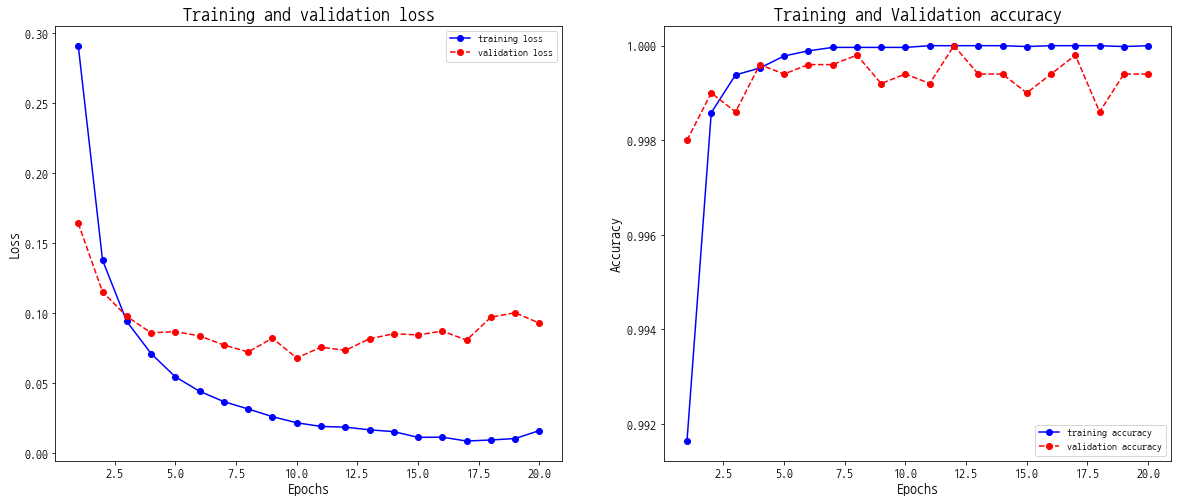

In [125]:
loss_and_acc_plot(history, class_mode="sparse_top_k_categorical_accuracy", validation=True)

In [126]:
# np.argmax(one_hot_test_labels, axis=1)
test_loss, test_acc = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 40s 4ms/sample - loss: 0.0974 - sparse_top_k_categorical_accuracy: 0.999416s - loss: 0.1251 - sparse_top_k_categorical_accu - ETA: 16s - loss: 0


In [130]:
[v.name for v in model.trainable_variables]

['dense/kernel:0',
 'dense/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'dense_1/kernel:0',
 'dense_1/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'dense_2/kernel:0',
 'dense_2/bias:0']

<br>

## 2.8 Classifying movie reviews: a binary classification example

2종 분류(two-class classification) 또는 이진 분류(binary classification)는 널리 적용된 머신러닝 문제입니다. 이 예제에서는 리뷰 텍스트를 기반으로 영화 리뷰를 긍정과 부정으로 분류합니다. 

<br>

### 2.8.1 The IMDB dataset

인터넷 영화 데이터베이스로부터 가져온 양극단의 리뷰 5만개로 이루어진 IMDB 데이터셋을 사용하겠습니다. 이 데이터셋은 훈련 데이터 2만 5천개와 테스트 데이터 2만 5천개로 나뉘어져있고 각각 50%는 부정, 50%는 긍정 리뷰로 구성되어 있습니다.  

훈련 데이터와 테스트 데이터를 나누는 이유는 같은 데이터에서 머신 러닝 모델을 훈련하고 테스트해서는 절대 안되게 때문입니다. 모델이 훈련 데이터에서 잘 작동한다는 것이 처음 만난 데이터에서도 잘 작동한다는 것을 보장하진 않습니다. 중요한 것은 새로운 데이터에 대한 모델의 성능입니다(사실 훈련 데이터의 레이블은 이미 알고 있기 때문에 이를 예측하는 모델은 필요하지 않습니다). 예를 들어 모델이 훈련 샘플과 타깃사이의 매핑을 모두 외울 수 있습니다. 이런 모델은 처음 만나는 데이터에서 타깃을 예측하는 작업에는 쓸모가 없습니다.  
이 데이터는 전처리 되어 있기 때문에 각 리뷰(단어 시퀀스)가 숫자 시퀀스로 변환되어 있습니다. 여기서 각 숫자는 사전에 있는 고유한 단어를 나타냅니다.

In [132]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)

<br> 
num_words=10000 매개변수는 훈련 데이터에서 가장 자주 나타는 단어 1만 개만 사용하겠다는 의미입니다. 이렇게 하면 적절한 크기의 벡터 데이터를 얻을 수 있습니다.  

변수 train_data와 test_data는 리뷰의 목록입니다. 각 리뷰는 단어 인덱스의 리스트입니다(단어 시퀀스가 인코딩 된 것). train_labels와 test_labels는 부정을 나타내는 0과 1의 리스트입니다.

In [133]:
np.array(train_data[0])

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

In [134]:
train_labels[0]

1

가장 자주 등장하는 단어 1만개로 제한했기 때문에 단어 인덱스의 최대는 9,999입니다.

In [135]:
seq_max = [max(sequence) for sequence in train_data]
max(seq_max)

9999

이 리뷰 데이터 하나를 원래 영어 단어로 바꾸겠습니다.

In [136]:
word_index = imdb.get_word_index() # word_index는 단어와 정수 인덱스를 매핑한 딕셔너리

In [137]:
# 정수 인덱스와 단어를 매핑
reverse_word_index = dict((value, key) for (key, value) in word_index.items())

# decoded_review
# 0, 1, 2는 "패딩", "문서시작", "사전에 없음"을 위한 인덱스이므로 이 값을 인덱스에서 제거하기 위해 음수로 만듭니다.
# get(argu1, argu2)는 dictionary에 argu1가 있으면 dictionary에서 값을 가져오고 그렇지 않으면 argu2를 출력합니다.
decoded_review = " ".join(
    [reverse_word_index.get(i-3, "?") for i in train_data[0]]
)

In [138]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

<br>

### 2.8.2 Preparing the data

신경망에 숫자 리스트를 주입할 수는 없습니다. 리스트를 텐서로 바꾸는 2가지 방법이 있습니다.  
 - 같은 길이가 되도록 리스트에 패딩(padding)을 추가하고 (samples, sequence_length)크기의 정수 텐서로 변환합니다(가장 긴 리뷰는 2,494개의 단어로 이루어져 있으므로 훈련 데이터를 변환한 텐서의 크기는 925000, 2494)가 됩니다). 그 다음이 정수 텐서를 다룰 수 있는 층을 신경망의 첫 번째 층으로 사용합니다(Embedding 층을 말합니다).  
 
- 리스트를 one-hot encoding하여 0과 1의 벡터로 변환합니다. 예를 들어 시퀀스 [3, 5]를 인덱스를 3과 5의 위치는 1이고 그외는 모두 0인 10,000차원의 벡터로 각각 변환합니다(리스트가 하나의 벡터로 변환되므로 훈련 데이터를 변환한 텐서의 크기는 (25000, 10000)이 됩니다). 그 다음 부동 소수 벡터 데이터를 다룰 수 있는 Dense층을 신경망의 첫 번째 층으로 사용합니다.

In [139]:
import numpy as np

def vectorize_sequence(sequences, dimension=10000):
    results = np.zeros([len(sequences), dimension])
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [140]:
X_train = vectorize_sequence(train_data)
X_test = vectorize_sequence(test_data)

이제 샘플을 다음과 같이 나타납니다.

레이블은 쉽게 벡터로 바꿀 수 있습니다.

In [141]:
y_train = np.asarray(train_labels).astype("float32").reshape(-1, 1)
y_test = np.asarray(train_labels).astype("float32").reshape(-1, 1)

훈련 데이터를 검증 데이터와 훈련 데이터로 나눕니다.

In [142]:
X_valid, X_train = X_train[:10000], X_train[10000:]
y_valid, y_train = y_train[:10000], y_train[10000:]

이제 신경망에 데이터를 주입할 준비가 되었습니다.

<br>

### 2.8.3 Building your network

입력 데이터가 벡터고 레이블은 스칼라(1 또는 0)입니다. 이런 문제에 잘 작동하는 네트워크 종류는 relu활성화 함수입니다.

In [143]:
def logit_relu(z):
    return np.maximum(0, z)

def logit_sigmoid(z):
    return 1 / (1 + np.exp(-z))

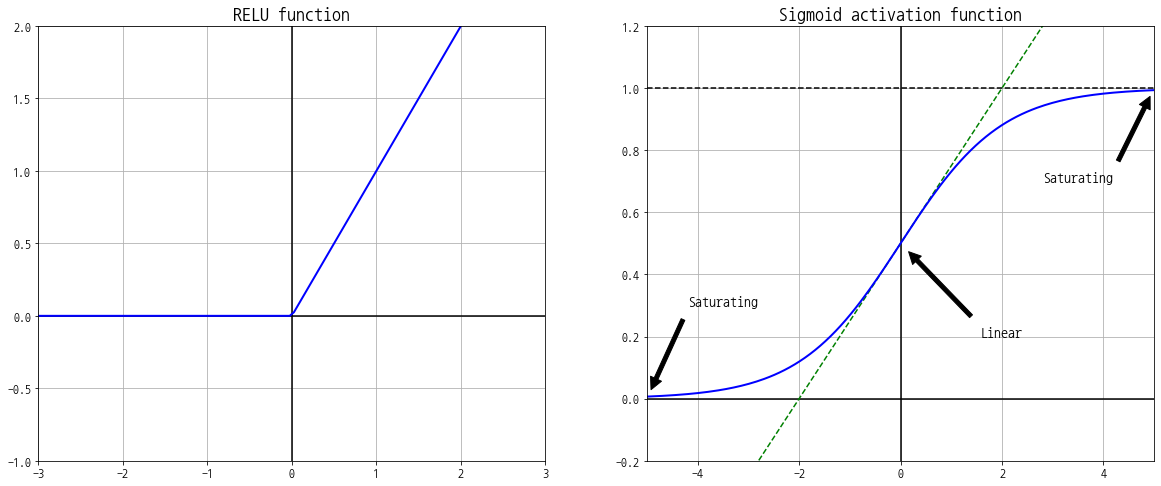

In [144]:
plt.figure(figsize=(20, 8))
z = np.linspace(-5, 5, 200)
plt.subplot(121)

plt.plot([-3, 3], [0, 0], 'k-')
plt.plot([0, 0], [-2, 2], 'k-')
plt.plot(z, logit_relu(z), "b-", linewidth=2)
plt.grid(True)
plt.title("RELU function", fontsize=18)
plt.axis([-3, 3, -1, 2], "equal")



plt.subplot(122)
z = np.linspace(-5, 5, 200)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit_sigmoid(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=18)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

```python
Dense(16, activation="relu")
```
16개의 은닉 유닛이 있다는 것은 가중치 행렬 W의 크기가 (input_dimension, 16)이라는 뜻입니다. 입력 데이터와 W를 점곱하면 입력 데이터가 16 차원으로 표현된 공간으로 투영됩니다(그리고 편향 벡터 b를 더하고 relu 연산을 적용합니다). 표현 공간의 차원을 '신경망이 내재된 표현을 학습할 때 가질 수 있는 자유도'로 이해할 수 있습니다. 은닉 유닛을 늘리면 (표현 공간을 더 고차원으로 만들면) 신경망이 더욱 복잡한 표현을 학습할 수 있지만 계산 비용이 커지고 원치 않은 패턴을 학습할 수도 있습니다(훈련 데이터에서는 성능이 향상되지만 테스트 데이터에서는 그렇지 않은 패턴입니다).

Dense 층을 쌓을 때 두 가진 중요한 구조상의 결정이 필요합니다:

- 얼마나 많은 층을 사용할 것인가
- 각 층에 얼마나 많은 은닉 유닛을 둘 것인가

모델은 다음의 층으로 구성합니다.  
- 16개의 은닉 유닛을 가진 두 개의 은닉층
- 현재 리뷰의 감정을 스칼라 값의 예측으로 출력하는 세 번째 층
중간에 있는 은닉층은 활성화 함수로 relu를 사용하고 마지막 층은 확률(0과 1 사이의 점수로, 어떤 샘플이 타깃 '1'일 가능성이 높다는 것은 그 리뷰가 긍정일 가능성이 높다는 것을 의미합니다)을 출력하기 위해 시그모이드 활성화 함수를 사용합니다. relu는 음수를 0으로 만드는 함수입니다. 시그모이드는 임의의 값을 [0, 1] 사이로 압축하므로 출력 값을 확률처럼 해석할 수 있습니다.

다음이 이 신경망의 모습입니다:

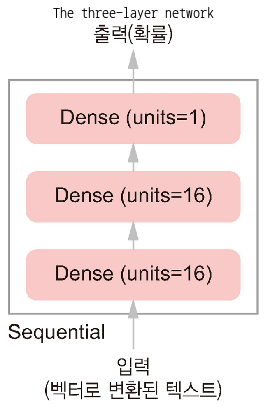

In [145]:
plt.figure(figsize=(12, 7))
plt.title("The three-layer network", fontsize=14)
plot_external2("./images/ch02/2.png")
plt.show()

In [146]:
clear_session()
from tensorflow.keras.layers import Dense

model = tf.keras.Sequential()
model.add(Dense(16, activation="relu", input_shape=(10000,)))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


<br> 
마지막으로 손실 함수와 옵티마이저를 선택해야 합니다. 이진 분류 문제고 신경망의 출력이 확률이기 때문에(네트워크의 끝에 시그모이드 활성화 함수를 사용한 하나의 유닛으로 된 층을 놓았습니다), binary_crossentropy 손실이 적합합니다. 또한 mean_squared_error도 사용할 수 있습니다. 확률을 출력하는 모델을 사용할 때는 binary_crossentropy가 최선의 선택입니다. 크로스엔트로피는 정보이론 분야에서 온 개념으로 확률 분포 간의 차이를 측정합니다. 여기에서는 원본 분포와 예측분포 사이를 측정합니다.  

다음은 옵티마이저와 binary_crossentropy손실 함수로 모델을 설정하는 단계입니다.

In [147]:
from tensorflow.keras import optimizers, losses, metrics

model.compile(optimizer=optimizers.Adam(), 
              loss= losses.binary_crossentropy, 
              metrics=[metrics.binary_accuracy])

<br>

### 2.8.4 Validating your approach

신경망에 데이터를 주입하기 전에 데이터가 적절하게 나눠졌는지 확인해보겠습니다.

In [148]:
print("훈련데이터의 크기 X: {}, y: {}".format(len(X_train), len(y_train)))
print("검증데이터의 크기 X: {}, y: {}".format(len(X_valid), len(y_valid)))
print("테스트데이터의 크기 X: {}, y: {}".format(len(X_test), len(y_test)))

훈련데이터의 크기 X: 15000, y: 15000
검증데이터의 크기 X: 10000, y: 10000
테스트데이터의 크기 X: 25000, y: 25000


<br>
이제 모델을 512개의 샘플씩 미니 배치를 만들어 20번의 에포크 동안 훈련시킵니다(X_train, y_train 텐서에 있는 모든 샘플에 대해 20번 반복합니다). 동시에 따로 떼어 놓은 1만 개의 샘플에서 손실과 정확도를 측정할 것입니다. 이렇게 하려면 validation_data 매개변수에 검증 데이터를 전달해야 합니다.

In [149]:
%%time
epochs=20
class_mode="binary_accuracy"
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=512, 
                    validation_data=(X_valid, y_valid), 
                    verbose=0, 
                    callbacks=[LossAndError(epochs=epochs, 
                                            class_mode=class_mode, 
                                            validation=True)])

epoch: 1, loss 0.33633, binary_accuracy 0.77553 
history key: ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']
Epoch 4/20 loss: 0.13954 binary_accuracy: 0.95700 val_loss: 0.28468 val_binary_accuracy: 0.88590
Epoch 8/20 loss: 0.04552 binary_accuracy: 0.99233 val_loss: 0.38536 val_binary_accuracy: 0.87890
Epoch 12/20 loss: 0.01509 binary_accuracy: 0.99947 val_loss: 0.49910 val_binary_accuracy: 0.86940
Epoch 16/20 loss: 0.00635 binary_accuracy: 0.99987 val_loss: 0.59108 val_binary_accuracy: 0.86780
Epoch 20/20 loss: 0.00333 binary_accuracy: 1.00000 val_loss: 0.66132 val_binary_accuracy: 0.86700
CPU times: user 2min 27s, sys: 1min 29s, total: 3min 56s
Wall time: 11min 17s


In [150]:
makedir("./models/ch02")
model.save("./models/ch02/binary_classification_imdb_1.h5")

directory exist!!


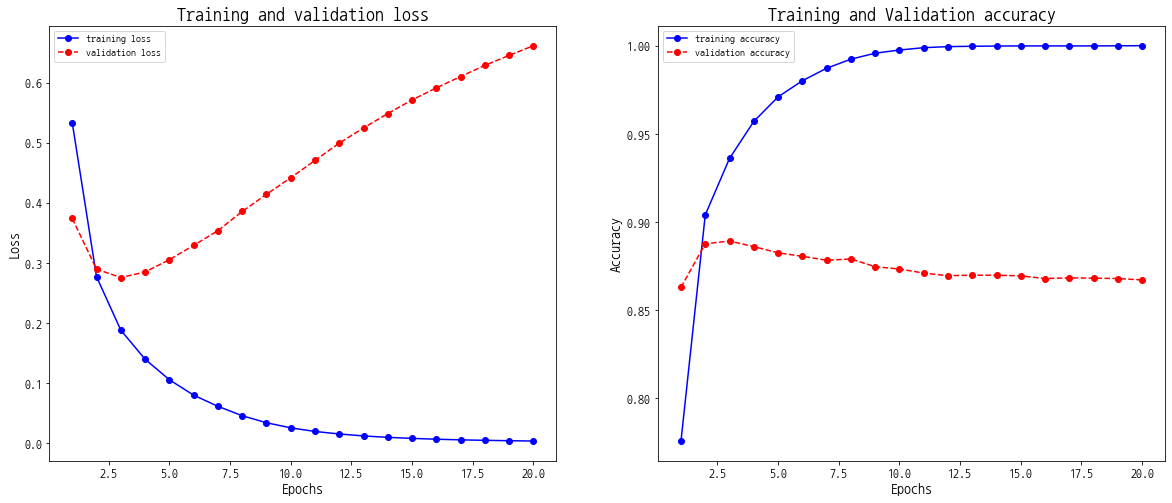

In [151]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

여기에서 알 수 있는 사실은 다음과 같습니다.  
- 훈련 손실이 에포크마다 **감소**하고, 훈련 정확도는 에포크마다 **증가**합니다.  
- 검증 손실과 정확도는 4번째 Epoch에서 그래프가 역전되는 것 같습니다.

이런 경우에 과대 적합을 방지하기 위해서 3번째 에포크 이후에 훈련을 중지할 수 있습니다.  

In [181]:
clear_session()
from tensorflow.keras.layers import Dense

model = tf.keras.Sequential()
model.add(Dense(16, activation="relu", input_shape=(10000,)))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [182]:
from tensorflow.keras import optimizers, losses, metrics

model.compile(optimizer=optimizers.Adam(), 
              loss= losses.binary_crossentropy, 
              metrics=[metrics.binary_accuracy])

In [183]:
%%time
epochs = 4
class_mode = "binary_accuracy"
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=512, 
                    verbose=0, 
                    callbacks=[LossAndError(epochs=epochs, 
                                            class_mode=class_mode,
                                            validation=False)])

epoch: 1, loss 0.46877, binary_accuracy 0.75393 
history key: ['loss', 'binary_accuracy']
Epoch 1/4 loss: 0.57247 binary_accuracy: 0.75393
Epoch 2/4 loss: 0.32263 binary_accuracy: 0.89840
Epoch 3/4 loss: 0.21214 binary_accuracy: 0.93080
Epoch 4/4 loss: 0.15651 binary_accuracy: 0.95067
CPU times: user 15.4 s, sys: 13.2 s, total: 28.6 s
Wall time: 1min 23s


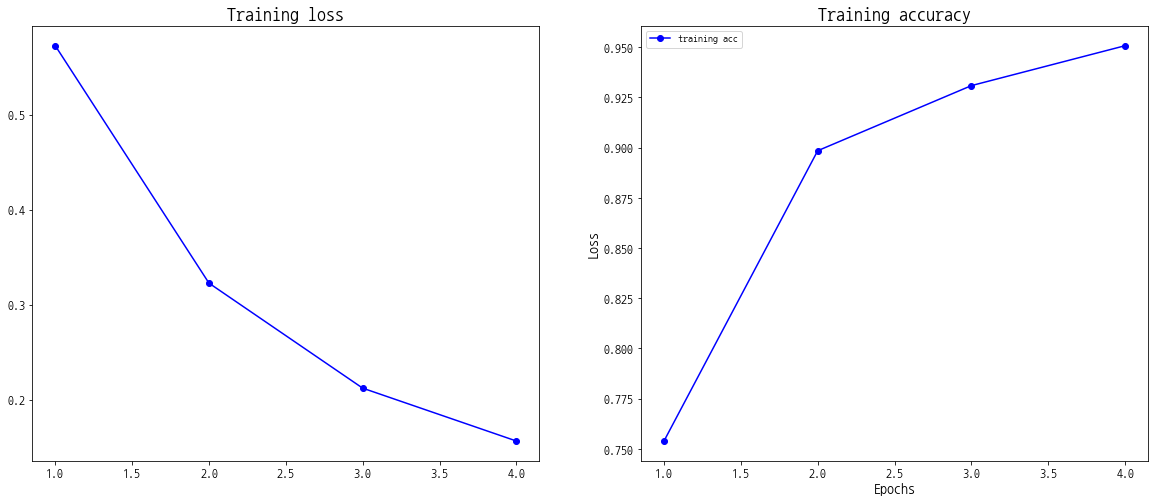

In [184]:
loss_and_acc_plot(history, class_mode=class_mode, validation=False)

In [185]:
results = model.evaluate(X_test, y_test)
results

25000/25000 [==============================] - 44s 2ms/sample - loss: 1.7804 - binary_accuracy: 0.5014ETA: 2s - loss: 1.7793 - b


[1.7803958633422852, 0.50136]

정확도는 49.9% 정도를 달성했습니다.

<br>

### 2.8.5 Using a trained network to generate predictions on new data

모델을 훈련시킨 후에 이를 실전 환경에서 사용하려면 predict 메서드를 사용하면 됩니다. predict 메서드를 사용해서 어떤 리뷰가 긍정일 확률을 예측할 수 있습니다(예측하려는 대상이 양성이 됩니다). 

In [186]:
prediction = model.predict(X_test)
prediction

array([[0.20975831],
       [0.999024  ],
       [0.8983388 ],
       ...,
       [0.049784  ],
       [0.13687104],
       [0.5953112 ]], dtype=float32)

이 확률이 0.5보다 크거나 같으면 1, 그렇지 않으면 0으로 이진화 합니다.

In [187]:
binary_prediction = np.where(prediction>=0.5, 1, 0)
binary_prediction

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [188]:
index, count = np.unique(binary_prediction, return_counts=True)

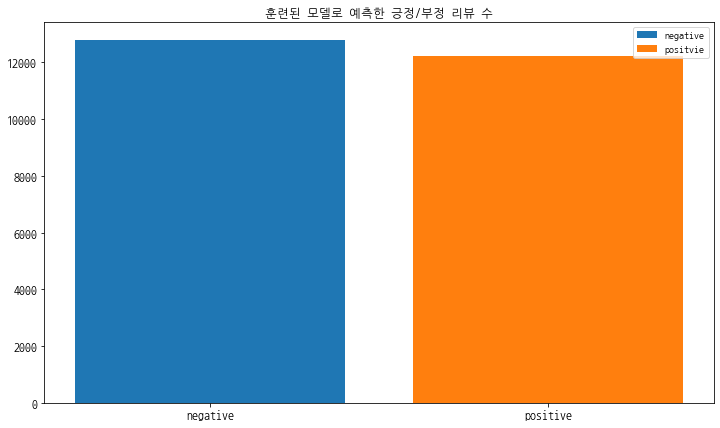

In [189]:
plt.figure(figsize=(12, 7))
plt.bar(index[0], count[0], label="negative")
plt.bar(index[1], count[1], label="positvie")
plt.legend()
plt.title("훈련된 모델로 예측한 긍정/부정 리뷰 수")
plt.xticks(index, ["negative", "positive"])
plt.show()